## Bayesian estimation of enzyme elasticities for an in vitro pathway

This notebook is derived from Wu2004.ipynb. 
Wu2004.ipynb uses a model and data from C. Giersch, European Journal of Biochemistry. 227, 194–201 (1995). 
However, instead of running just one model, this notebook will run analysis for a batch of models. 
This notebook is designed to run within the framework of the following files:
- `generating_synthetic_models.ipynb`
- `generated_model_analysis.ipynb`


In [1]:
import numpy as np
np.random.seed(0)

import pandas as pd
pd.set_option
('display.max_columns', None)
pd.set_option('display.max_rows', None)

import scipy
import scipy.stats

import pymc as pm
import aesara
import cobra
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})

import emll
import sys
np.set_printoptions(threshold=sys.maxsize)

import tellurium as te
import os


WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [9]:
FOLDER_NAME = '10sp/'
with open(FOLDER_NAME + "passlist.txt") as file:
    passlist = [line.rstrip() for line in file]

DATA_OMISSION_CODE = 'A'

# test_no = "38"
# script_name = "all_data"
# dataset_name = f"10sp_{test_no}_10"

Here we load the antimony model from SBbadger and construct the model using the `cobrapy` package, to get the stochiometric and reference flux matrices.

In [8]:
for i, modelPath in tqdm(enumerate(os.listdir(FOLDER_NAME + 'sbml/'))):
    print(modelPath)
    r, model = loadModels(modelPath)
    datasets = locateData(i)
    for dataFile in datasets: 
        runInference(r, model, dataFile)

0it [00:00, ?it/s]

test_sbml_106.sbml


OSError: The file with 'test_sbml_106.sbml' does not exist, or is not an SBML string. Provide the path to an existing SBML file or a valid SBML string representation:


In [10]:
def loadModels(path):
    r = te.loads(FOLDER_NAME + 'sbml/' + path)
    N = r.getFullStoichiometryMatrix()
    nm, nr = N.shape
    model = cobra.io.read_sbml_model(FOLDER_NAME + 'sbml/' + path)
    
    ex_list = [i.id for i in list(model.reactions) if 'EX' in i.id]
    model.remove_reactions(ex_list)
    
    removable_mets = [i for i in list(model.metabolites) if 'B' in i.id]
    
    # if removable_mets in a reaction, write down the name of the reaction
    # this code assumes that there will only be one source and one sink
    ex_sp_rxns = [list(model.metabolites.get_by_id(m.id).reactions)[0].id for m in removable_mets]

    model.remove_metabolites(i)  
    
    return r, model

In [11]:
def locateData(passN):
    datasets = []
    for dataset in os.listdir(FOLDER_NAME + 'generated_data/'):
        if f'data_{passlist[passN]}_' in b:
            datasets.append(b)
    return datasets

In [12]:
def runInference(r, model, dataPath):
    data = pd.read_csv(dataPath).astype(float)
    n_exp = len(data)   

    e_cols = [col for col in data.columns if 'E' in col]
    x_cols = r.getFloatingSpeciesIds()    
    y_cols = [col for col in r.getBoundarySpeciesIds() if 'S' in col]
    v_cols = [col for col in data.columns if 'flux' in col]

    e = data[e_cols]
    x = data[x_cols]
    y = data[y_cols]
    v = data[v_cols].iloc[:,:SYN_DEGR]

    ref_ind = 0 ## corresponds to how the data was generated

    e_star = e.iloc[ref_ind].values
    x_star = x.iloc[ref_ind].values
    y_star = y.iloc[ref_ind].values
    v_star = v.iloc[ref_ind].values

    # Normalize to reference values (and drop trivial measurement)
    en = e.values / e_star
    xn = np.log(x.values / x_star)
    yn = np.log(y.values / y_star)
    vn = v.values / v_star[ref_ind]

    N[:, v_star < 0] = -1 * N[:, v_star < 0]
    v_star = np.abs(v_star)

    v_star[v_star == 0] = 1e-12

    Ex = emll.create_elasticity_matrix(model)
    Ey = createEy()

    ll = emll.LinLogLeastNorm(N, Ex, Ey, v_star) 

    m_labels = [m.id for m in model.metabolites]
    r_labels = [r.id for r in model.reactions]
    y_labels = ex_sp_rxns

    ex_labels = np.array([['$\epsilon_{' + '{0},{1}'.format(rlabel, mlabel) + '}$'
                        for mlabel in m_labels] for rlabel in r_labels]).flatten()
    ey_labels = np.array([['$\epsilon_{' + '{0},{1}'.format(rlabel, mlabel) + '}$'
                        for mlabel in y_labels] for rlabel in r_labels]).flatten()

    e_labels = np.hstack((ex_labels, ey_labels))


In [31]:
def createEy(removable_mets, ex_sp_rxns):
    Ey = np.zeros((nr, y.shape[1])) # (reactions, number of external species)

    # external species reaction number--the reaction number where the external species appears? (list)
    ex_sp_rxn_ns = [i[1:] for i in ex_sp_rxns]

    # for each external species:    
    for i, met in enumerate(removable_mets): 
        Ey[ex_sp_rxn_ns[i], i] = 1
    return Ey

_How to automate this bit?_

Load experimental data from a CSV file

Here we chop up the experimental data into the e, y, v, and x vectors; and normalize them to the reference state 
Since this model does not have any external species, there are no y values. 
The values in v_star were obtained by simulating the pathway's steady state in roadrunner. 
The ref_ind was chosen as it was the only simulated run where nothing was perturbed.

In [10]:
y_cols

['S5', 'S8']

In [11]:
for met in removable_mets: 
    x = str(met)[-1]
    for i in model.metabolites:
        if x in i.id:
            model.remove_metabolites(i)
model.metabolites

[<Metabolite S0 at 0x1f127b87340>,
 <Metabolite S1 at 0x1f127b87430>,
 <Metabolite S2 at 0x1f127b874f0>,
 <Metabolite S3 at 0x1f127b87490>,
 <Metabolite S4 at 0x1f127b87460>,
 <Metabolite S6 at 0x1f127b87550>,
 <Metabolite S7 at 0x1f127b87580>,
 <Metabolite S9 at 0x1f127b875e0>]

Here we initialize the `LinLogModel` object, which holds some convenience routines. We just use default values for the elasticity matricies.

In [14]:
# Correct negative flux values at the reference state
# first the N values corresponding with negative v_star values must be corrected
N[:, v_star < 0] = -1 * N[:, v_star < 0]
# then negative v_star values must be corrected
v_star = np.abs(v_star)

# Correct all 0 fluxes. Cannot divide nor take log of 0
v_star[v_star == 0] = 1e-12

In [15]:
#Ex.shape (15,8)
#Ey.shape (13,2)

In [16]:
os.chdir('C:\\Users\\user\\Documents\\research\\Gayles\\benchmarking')



## Specify the full probability model

This is the real meat of the inference problem, where we specify the full probability model for our elasticity matricies and observed steady-state responses.

In [18]:
import os
os.getcwd()
os.chdir('C:\\Users\\user\\Documents\\research\\Gayles\\benchmarking')

c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\tensor\elemwise.py:788: RuntimeWarning:

divide by zero encountered in log



Text(0, 0.5, 'Probability density')

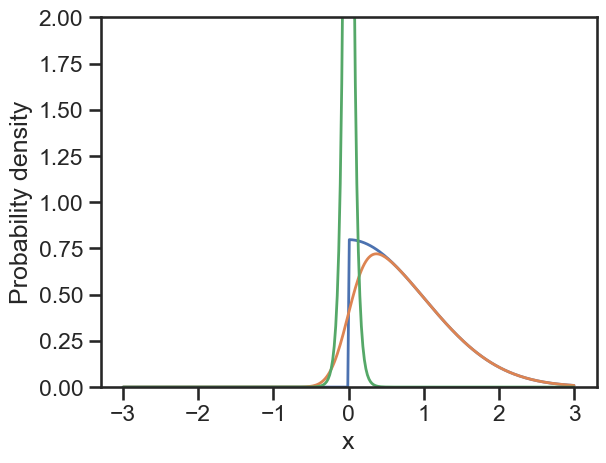

In [19]:
normal_dist = pm.HalfNormal.dist(sigma=1)
t_dist = pm.SkewNormal.dist(mu=0, sigma=1, alpha=5)
s_dist = pm.Laplace.dist(mu=0, b=0.05)

x_eval = np.linspace(-3, 3, 300)
plt.plot(x_eval, aesara.tensor.exp(pm.logp(normal_dist, x_eval)).eval(), lw=2.) # blue
plt.plot(x_eval, aesara.tensor.exp(pm.logp(t_dist, x_eval)).eval(), lw=2.) # orange
plt.plot(x_eval, aesara.tensor.exp(pm.logp(s_dist,x_eval)).eval(), lw=2.) # green

plt.ylim([0, 2])

plt.xlabel('x')
plt.ylabel('Probability density')

Here's the actual sampling code. First we add our prior distributions on the elasticity matrices and sample the prior predictive distribution. We use the convienence function 'initialize_elasticity' to create the relevant matrix.

In [20]:
from emll.util import initialize_elasticity

#print(initialize_elasticity.__doc__)

In [21]:
with pm.Model() as pymc_model:
    
    # Initialize elasticities
    Ex_t = pm.Deterministic('Ex', initialize_elasticity(N, 'ex', b=0.05, sd=1, alpha=5))
    Ey_t = pm.Deterministic('Ey', initialize_elasticity(-Ey.T, 'ey', b=0.05, sd=1, alpha=5))

# T.printing.Print('Ex_t')(Ex_t) # Ex_t is a 6x4 matrix
# T.printing.Print('Ey_t')(Ey_t) # Ey_t is a 6x3 matrix

In [22]:
with pymc_model:
    trace_prior = pm.sample_prior_predictive()

Sampling: [ex_capacity_entries, ex_kinetic_entries, ey_capacity_entries, ey_kinetic_entries]


In [23]:
"""
FCC_priors = np.array([ll.flux_control_coefficient(Ex=ex) for ex in trace_prior['Ex']])
FCC_pri_a = pd.DataFrame(FCC_priors[:, 0], columns=[r.id for r in model.reactions]
                  ).stack().reset_index(level=1)
FCC_pri_a.reset_index(inplace=True) ## you can only run this line once!
FCC_pri_b = pd.pivot_table(FCC_pri_a, values=0, index=['index'], columns=['level_1'])
FCC_pri_c = FCC_pri_b.apply(pm.hpd).dropna()
FCC_priors = pd.DataFrame(FCC_pri_c, columns=r_labels)
FCC_priors.to_csv(f'CSVs/{script_name}-{dataset_name}-FCC_priors.csv') # doesn't exist
"""

"\nFCC_priors = np.array([ll.flux_control_coefficient(Ex=ex) for ex in trace_prior['Ex']])\nFCC_pri_a = pd.DataFrame(FCC_priors[:, 0], columns=[r.id for r in model.reactions]\n                  ).stack().reset_index(level=1)\nFCC_pri_a.reset_index(inplace=True) ## you can only run this line once!\nFCC_pri_b = pd.pivot_table(FCC_pri_a, values=0, index=['index'], columns=['level_1'])\nFCC_pri_c = FCC_pri_b.apply(pm.hpd).dropna()\nFCC_priors = pd.DataFrame(FCC_pri_c, columns=r_labels)\nFCC_priors.to_csv(f'CSVs/{script_name}-{dataset_name}-FCC_priors.csv') # doesn't exist\n"

In [24]:
with pymc_model:
        
    # Error priors. 
    v_err = pm.HalfNormal('v_error', sigma=0.05, initval=.1)
    x_err = pm.HalfNormal('x_error', sigma=0.05, initval=.1) # shape must match so that pm.Normal() runs successfully

    # Calculate steady-state concentrations and fluxes from elasticities
    chi_ss, v_hat_ss = ll.steady_state_aesara(Ex_t, Ey_t, en, yn)

    # Error distributions for observed steady-state concentrations and fluxes
    
    v_hat_obs = pm.Normal('v_hat_obs', mu=v_hat_ss, sigma=v_err, observed=vn) # both bn and v_hat_ss are (28,6)
    chi_obs = pm.Normal('chi_obs', mu=chi_ss,  sigma=x_err,  observed=xn) # chi_ss and xn is (28,4)

#print(pymc_model.logpt.tag.test_value)

This is the actual computationally intensive portion, where we sample the posterior distribution using hamiltonian monte carlo.

## Equivalent approach using variational inference

Here we approximate the posterior distribution using ADVI to compare the two methods.

In [25]:
# estimated to take 2 and a half days for 30k iterations
with pymc_model:
    approx = pm.ADVI()
    hist = approx.fit(n=30000, obj_optimizer=pm.adagrad_window(learning_rate=5E-3), obj_n_mc=1)

c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 2,843.1


AttributeError: module 'pymc' has no attribute 'sample_ppc'

In [27]:
with pymc_model:
    trace_vi = hist.sample(1000)
    
    
    ppc_vi = pm.sample_posterior_predictive(trace_vi, random_seed=1)

Sampling: [chi_obs, v_hat_obs]


ADVI is an optimization-based method, so we monitor the evidence lower bound to check convergence

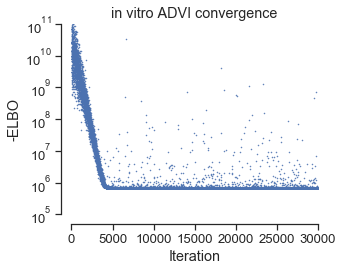

In [ ]:
with sns.plotting_context('notebook', font_scale=1.2):

    fig = plt.figure(figsize=(5,4))
    plt.plot(approx.hist + 30, '.', rasterized=True, ms=1)
    plt.yscale("log")
    plt.ylim([1E5, 1E11])
    plt.xlim([0, 30000])
    sns.despine(trim=True, offset=10)

    plt.ylabel('-ELBO')
    plt.xlabel('Iteration')
    plt.title('in vitro ADVI convergence')
    plt.tight_layout()
    # plt.savefig('wu_elbo.svg', transparent=True, dpi=200)

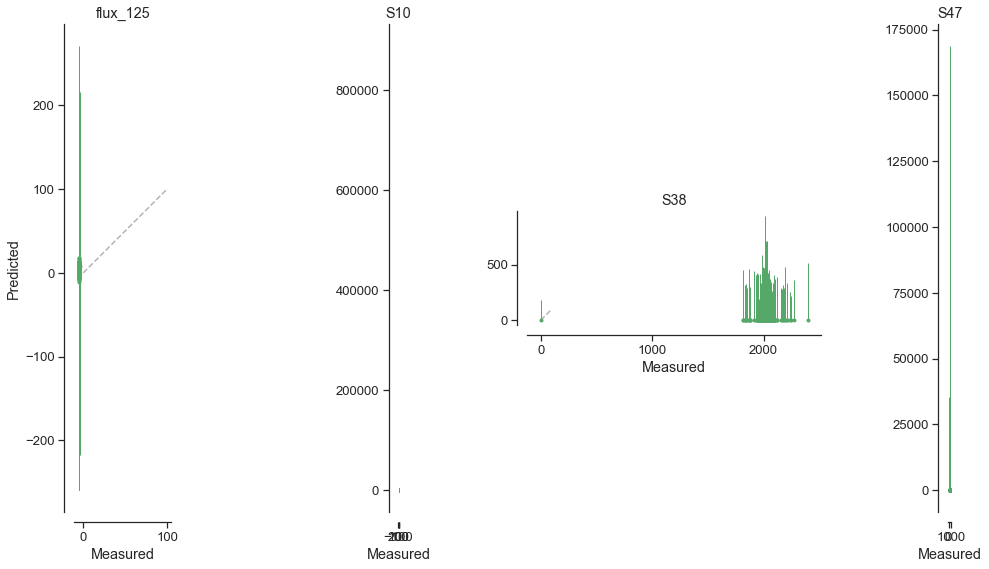

In [ ]:
# this plot is for comparing measured and posterior predicted values of metabolite concentrations and flux
with sns.plotting_context('notebook', font_scale=1.2):

    fig, axmatrix = plt.subplots(ncols=4, figsize=(16,8))
    # 6 columns, 1 for each internal species, 1 for each terminal flux

    for ax in axmatrix.flatten():
        ax.set_aspect('equal')

    def plot_hpd_err(truth, ppc, ax, color=None):
        median = np.median(ppc, 0) # (28, 6)
        hpd = pm.hpd(ppc)
        err = np.abs(hpd - median[:, np.newaxis])
        return ax.errorbar(truth, median, yerr=err.T, ls='',marker='.', elinewidth=1., color=color)

    # ADVI analysis
    plot_hpd_err(v['flux_125'].values, v_star[3] * ppc_vi['v_hat_obs'][:,:,3], axmatrix[0], 'g')
    
    plot_hpd_err(x['S10'].values, x_star[0] * np.exp(ppc_vi['chi_obs'][:,:,0]), axmatrix[1], 'g')
    plot_hpd_err(x['S38'].values, x_star[1] * np.exp(ppc_vi['chi_obs'][:,:,1]), axmatrix[2], 'g')
    plot_hpd_err(x['S47'].values, x_star[2] * np.exp(ppc_vi['chi_obs'][:,:,2]), axmatrix[3], 'g')
        
    # plt.suptitle(f'{script_name}: {dataset_name}', y=0.7)

    axmatrix[0].set_title('flux_125')
    axmatrix[1].set_title('S10')
    axmatrix[2].set_title('S38')
    axmatrix[3].set_title('S47')
    
    axmatrix[0].set_ylabel('Predicted')
    axmatrix[0].set_xlabel('Measured')
    axmatrix[1].set_xlabel('Measured')
    axmatrix[2].set_xlabel('Measured')
    axmatrix[3].set_xlabel('Measured')
    
    fig.tight_layout()

    ax0 = [0, 100]
    # axmatrix[0].set_ylim(ax0)
    axmatrix[0].plot(ax0, ax0, '--', color='.7', zorder=0)
    
    ax1 = [0, 100]
    #axmatrix[1].set_ylim(ax1)
    axmatrix[1].plot(ax1, ax1, '--', color='.7', zorder=0)

    ax2 = [0, 100]
    #axmatrix[1].set_ylim(ax1)
    axmatrix[2].plot(ax2, ax2, '--', color='.7', zorder=0)

    ax3 = [0, 100]
    #axmatrix[3].set_ylim(ax1)
    axmatrix[3].plot(ax3, ax3, '--', color='.7', zorder=0)

    
    sns.despine(trim=False, offset=10) # gets rid of the boxing
    plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=True)

    #fig.savefig(f'advi_graphs/{script_name}-{dataset_name}-pcc_predictions.svg')

In [ ]:
ex_vi = trace_vi['Ex'].reshape((len(trace_vi), -1))
ey_vi = trace_vi['Ey'].reshape((len(trace_vi), -1))
e_all_vi = np.hstack([ex_vi, ey_vi])

e_df_vi = pd.DataFrame(e_all_vi, columns=e_labels)
elasticities_vi = e_df_vi.apply(pm.hpd)
elasticities_vi.to_csv(f'CSVs/{script_name}-{dataset_name}-ADVI_predicted_elasticities.csv')

Here we calculate the flux control coefficients for both the ADVI and NUTS posteriors

In [ ]:
fcc_mb = np.array([ll.flux_control_coefficient(Ex=ex) for ex in trace_vi['Ex']]) # ADVI
# fcc_prior = np.array([ll.flux_control_coefficient(Ex=ex) for ex in trace_prior['Ex']])

In [ ]:
df2 = pd.DataFrame(fcc_mb[:, 0], columns=[r.id for r in model.reactions]
                  ).stack().reset_index(level=1)
df3 = pd.DataFrame(fcc_prior[:, 0], columns=[r.id for r in model.reactions]
                  ).stack().reset_index(level=1)

df2['type'] = 'ADVI'
df3['type'] = 'Prior'

fcc_df = pd.concat([df2, df3])
fcc_df.columns = ['Reaction', 'FCC', 'Type']

fcc_df.loc[fcc_df.FCC < -.5, 'FCC'] = np.nan
fcc_df.loc[fcc_df.FCC > 1.5, 'FCC'] = np.nan

In [ ]:
medians = list()
for r in e.columns.values:
    vals = df2[df2['level_1'] == r]
    vals.columns = ['_', 'val', '__']
    medians.append(vals['val'].median())
median_df = pd.DataFrame(medians)
median_df.to_csv(f'CSVs/{script_name}-{dataset_name}-median_FCCs.csv')

NameError: name 'fcc_df' is not defined

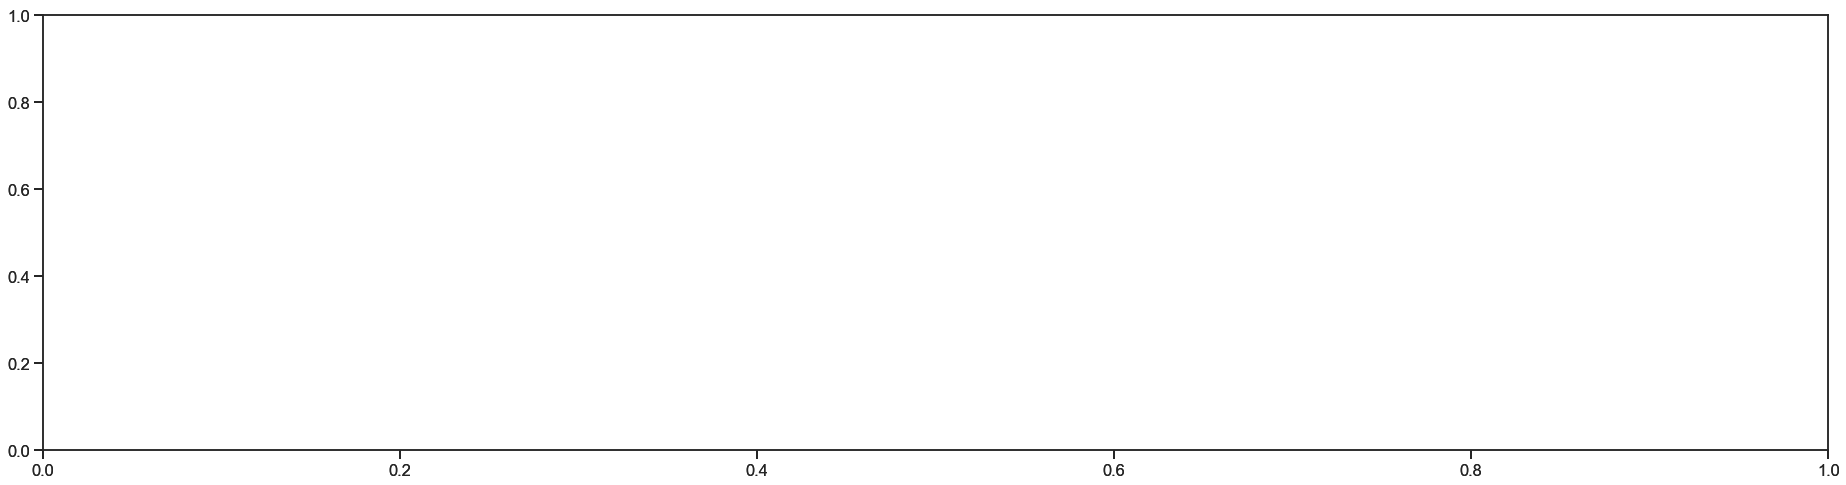

In [ ]:
fig = plt.figure(figsize=(16, 8))

# my_pal = {"Prior": ".8", "NUTS": "g", "ADVI":"b"}
my_pal = {"Prior": ".8", "ADVI":"b"}

ax = fig.add_subplot(111)
ax2 = fig.add_subplot(111, frameon=False, sharex=ax, sharey=ax)

sns.violinplot(
    x='Reaction', y='FCC', hue='Type', data=fcc_df[fcc_df.Type == 'Prior'],
    scale='width', width=0.5, legend=False, zorder=0,
    color='1.', ax=ax, saturation=1., alpha=0.01)

plt.setp(ax.lines, color='.8')
plt.setp(ax.collections, alpha=.5, label="")


sns.violinplot(
    x='Reaction', y='FCC', hue='Type', data=fcc_df,
    scale='width', width=0.8, hue_order=['ADVI'],
    legend=False, palette=my_pal, zorder=3, ax=ax2)

gt_FCCs = [9.71E-01,-2.10E-04,-7.91E-06,5.78E-04,-3.97E-02,2.78E-02,2.38E-06,2.09E-04,-7.72E-02,5.00E-01,-4.09E-03,1.54E-02,1.12E-06,9.19E-02,1.79E-03,-2.28E-03,-8.15E-02,1.51E-03,-5.85E-02,-8.93E-05,-6.62E-03,6.65E-03,-3.07E-03,9.52E-05,1.55E-05,-9.69E-05,-2.37E-04,1.74E-02,-1.10E-02,1.13E-02,4.45E-04,-3.45E-04,-2.35E-02,6.99E-05,-5.59E-02,2.18E-05,1.89E-03,5.30E-04,-4.17E-03,2.61E-02,4.09E-02,9.34E-03,1.40E-01,-7.51E-02,-1.74E-02,1.05E-02,-4.30E-07,2.07E-03,2.67E-05,9.53E-02,1.57E-01,1.76E-01,-1.03E-02,-1.38E-01,-9.56E-05,8.39E-02,-4.02E-02,-1.11E-06,5.69E-03,1.56E-04,3.14E-02,2.85E-05,1.59E-01,2.24E-02,-5.54E-05,-8.48E-07,4.05E-02,-6.05E-01,-1.70E-01,4.47E-04,-6.05E-05,-7.00E-01,-1.29E-01,-2.46E-04,-2.53E-07,9.79E-04,-2.09E-02,-5.97E-04,2.26E-01,-2.48E-01,1.11E-02,-1.45E-01,5.94E-04,-5.96E-04,5.90E-03,-2.05E-03,-2.56E-06,-4.95E-04,1.90E-03,4.61E-04,-2.93E-03,-5.10E-01,7.20E-01,-1.21E-04,7.14E-02,-7.11E-02,-3.46E-04,-2.77E-01,-9.84E-05,1.64E-06,-1.02E-02,2.18E-03,-4.34E-02,1.47E-02,-3.98E-04,7.74E-03,-2.28E-01,-5.09E-02,-4.11E-03,-4.62E-05,1.29E-04,1.98E-02,-7.64E-06,-9.89E-03,1.16E-02,3.07E-05,6.17E-02,2.71E-02,-2.57E-04,2.30E-02,-3.40E-03,3.32E-01,2.34E-04,-4.86E-08,7.44E-04,-1.98E-03,-9.90E-04,-6.33E-04,-1.75E-02,6.50E-03,1.54E-04,2.33E-05,1.06E-02,-4.90E-01,-4.18E-02,-4.88E-04,-4.57E-05,-1.57E-01,-7.01E-03,-7.65E-02,7.03E-01,1.63E-01,3.70E-02,2.16E-07,-6.34E-07,1.27E-01,4.21E-01,-2.80E-02,-3.43E-03,1.09E-02,1.06E-05,-2.01E-05,4.17E-02,-1.47E-04,1.17E-04]
for i, cc in enumerate(gt_FCCs):
    l = plt.plot([i - .4, i + .4], [cc, cc], '-', color=sns.color_palette('muted')[3])

phandles, plabels = ax.get_legend_handles_labels()
handles, labels = ax2.get_legend_handles_labels()
ax.legend().remove()
ax2.legend().remove()

ax2.legend(phandles + handles + l, plabels + labels + ['Ground Truth'], loc='upper center', ncol=4, fontsize=13)
ax.set_ylim([-1, 2])

ax.axhline(0, ls='--', color='.7', zorder=0)
sns.despine(trim=True)

plt.suptitle(f'{script_name}: {dataset_name}', y=1)

fig.savefig(f'advi_graphs/{script_name}-{dataset_name}-FCCs.svg', transparent=True)

# Making a better graph of the FCCs
Here I attempt to find 20 highest magnitude values from the ADVI algorithm and compare them with the 20 highest magnitude values that are known from the ground truth

In [ ]:
#fcc_df.reset_index(inplace=True) ## you can only run this line once!

a = pd.pivot_table(fcc_df, values='FCC', index=['index'], columns=['Reaction'])
b = a.apply(pm.hpd).dropna()
b.to_csv(f'CSVs/{script_name}-{dataset_name}-FCCs_hpd.csv')
c = b.abs().transpose()
predicted_20 = c.nlargest(20, [0]).index.values

## WHERE IS J0??????????

compare medians with hpds

In [ ]:
c.nlargest(20, [0])

,0
Reaction,
J59,0.499960
J32,0.499918
J71,0.499915
J140,0.499913
J113,0.499902
J108,0.499902
J127,0.499867
J60,0.499863
J31,0.499844


In [ ]:
abs_gt_FCCs = res =  [abs(ele) for ele in gt_FCCs]
actual_20 = sorted(range(len(abs_gt_FCCs)), key=lambda i: abs_gt_FCCs[i])[-20:]
for a in actual_20:
    print(a, abs_gt_FCCs[a])

50 0.157
137 0.157
62 0.159
141 0.163
68 0.17
51 0.176
78 0.226
106 0.228
79 0.248
97 0.277
121 0.332
146 0.421
133 0.49
9 0.5
91 0.51
67 0.605
71 0.7
140 0.703
92 0.72
0 0.971


making the violin plot again, but with hpds instead of priors

*the plot below is not yet correct nor complete*

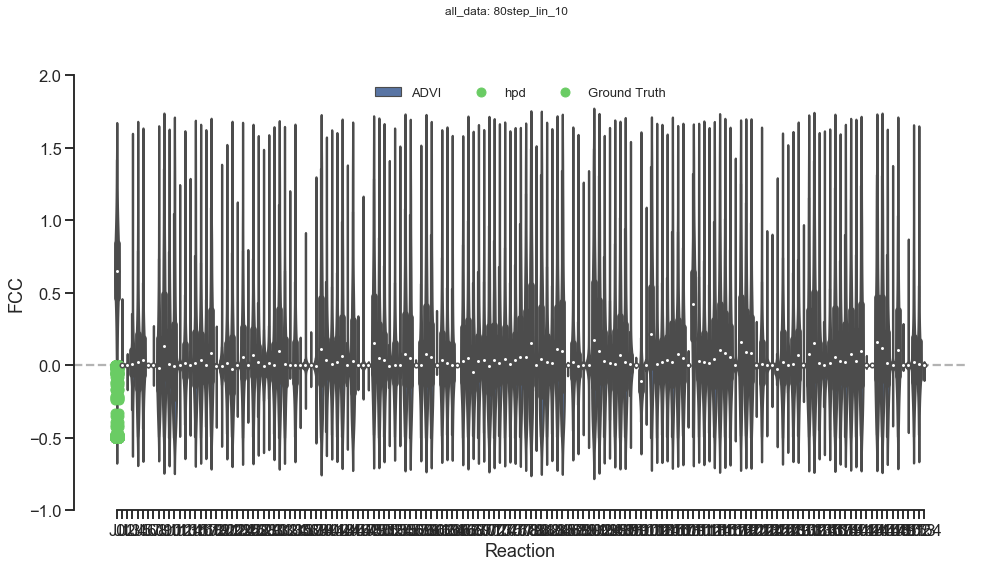

In [ ]:
fig = plt.figure(figsize=(16, 8))

my_pal = {"ADVI":"b"}

ax = fig.add_subplot(111)

plt.setp(ax.lines, color='.8')
plt.setp(ax.collections, alpha=.5, label="")

sns.violinplot(
    x='Reaction', y='FCC', hue='Type', data=fcc_df,
    scale='width', width=0.8, hue_order=['ADVI'],
    legend=False, palette=my_pal, zorder=3, ax=ax)

ADVI_hpd = b.values.tolist()
for i, cc in enumerate(ADVI_hpd):
    h = plt.plot([i - .4, i + .4], [cc, cc], 'o', color=sns.color_palette('muted')[2])

handles, labels = ax.get_legend_handles_labels()
ax.legend().remove()

ax.legend(handles + h + l, labels + ['hpd'] + ['Ground Truth'], loc='upper center', ncol=4, fontsize=13)
ax.set_ylim([-1, 2])

ax.axhline(0, ls='--', color='.7', zorder=0)
sns.despine(trim=True)

plt.suptitle(f'{script_name}: {dataset_name}', y=1)

fig.savefig(f'advi_graphs/{script_name}-{dataset_name}-FCCs_hpd_noPrior.svg', transparent=True)

In [ ]:
"""
import matplotlib.lines as mlines
vi_line = mlines.Line2D([], [], color='.6', ls='--', label='ADVI')

fig, axmatrix = plt.subplots(nrows=2, sharex=False, figsize=(10,5))
    
colors = sns.color_palette('husl', n_colors=e_all_vi.shape[-1])

for i, color in enumerate(colors[:ex_vi.shape[1]]):
    sns.kdeplot(ex_vi[:, i], ls='--', color=color, ax=axmatrix[0])
    
gt_Ex = [-0.63379, 1.04209, -0.491646, 1.21774, -0.782689, 1.12016, -0.694251, 1.14085, 1.42235]
for l in gt_Ex: # plot the ground truth values 
    axmatrix[0].axvline(l, 0, 1) 

axmatrix[0].set_xlim([-1, 1.5])
axmatrix[0].set_title('$\epsilon_x^*$')
axmatrix[0].set_ylabel('Frequency')
axmatrix[0].legend(handles=[vi_line], loc='upper right')

for i, color in enumerate(colors[ex_vi.shape[1]:]):
    sns.kdeplot(ey_vi[:, i], ls='--', color=color, ax=axmatrix[1])

gt_Ey = [0.9843063874738285, -0.9649533503183951, -1.1953481808173634]
for l in gt_Ey: # plot the ground truth values 
    axmatrix[1].axvline(l, 0, 1) 

axmatrix[1].set_xlim([-1.5, 1.5])
axmatrix[1].set_title('$\epsilon_y^*$')
axmatrix[1].set_ylabel('Frequency')


plt.tight_layout()
sns.despine(trim=True, offset=5)
fig.savefig(f'advi_graphs/{script_name}-{dataset_name}-elasticityDistributions.svg', transparent=True)"""

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x0000024346479378> (for post_execute):


KeyboardInterrupt: 